In [1]:
!pip install sidetable
!pip install scorecardpy
!pip install monotonic_binning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=23b7d6a42bcb0597a0ea000ce8372c434464dd2a71c692b6a08e3f3cc9e71dcd
  Stored in directory: /root/.cache/pip/wheels/68/88/65/58d6aa058698c47d7a24352952ea07a1409cc2eff3a8087c0c
Successfully built scorecardpy


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable
import scorecardpy as sc
from monotonic_binning.monotonic_woe_binning import Binning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer

In [4]:
# Load the cleaned dataset
df = pd.read_csv('data.csv')

# # Feature Engineering

## Create agregget features

In [5]:
# Group by CustomerId to create aggregate features
aggregate_features = df.groupby('CustomerId').agg({
    'Amount': ['sum', 'mean', 'count', 'std'],  # Total, Average, Count, Std Dev of transaction amounts
    'Value': ['sum', 'mean']  # Total and Average transaction value
})

# Flatten the multi-level column index
aggregate_features.columns = ['_'.join(col).strip() for col in aggregate_features.columns.values]

# Reset index to merge back with the original dataframe
aggregate_features = aggregate_features.reset_index()

# Merge aggregate features back into the original dataframe
df = pd.merge(df, aggregate_features, on='CustomerId', how='left')

## Extract Features from Transaction Timestamp

In [6]:
# Convert TransactionStartTime to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Extract features from the timestamp
df['TransactionHour'] = df['TransactionStartTime'].dt.hour
df['TransactionDay'] = df['TransactionStartTime'].dt.day
df['TransactionMonth'] = df['TransactionStartTime'].dt.month
df['TransactionYear'] = df['TransactionStartTime'].dt.year

## Drop less important columns

In [7]:
# Drop BatchId, SubscriptionId, ChannelId,CurrencyCode,CountryCode
df = df.drop(['BatchId', 'SubscriptionId', 'ChannelId', 'CurrencyCode', 'CountryCode'], axis=1)

##  Encode Categorical Variables

In [ ]:
# identify the number of  categorical columns
#categorical_columns = df.select_dtypes(include=['object']).columns
#categorical_columns

In [ ]:
# one-hot encode 'ProviderId', 'ProductId', 'ProductCategory' columns
#df = pd.get_dummies(df, columns=['ProviderId', 'ProductId', 'ProductCategory'], drop_first=True)

##  Handle Missing Values

In [8]:
df.isna().sum()

,0
TransactionId,0
AccountId,0
CustomerId,0
ProviderId,0
ProductId,0
ProductCategory,0
Amount,0
Value,0
TransactionStartTime,0
PricingStrategy,0


In [9]:
# Impute missing values with mean
df['Amount_std'] = df['Amount_std'].fillna(df['Amount_std'].mean())

In [10]:
df.isna().sum()

,0
TransactionId,0
AccountId,0
CustomerId,0
ProviderId,0
ProductId,0
ProductCategory,0
Amount,0
Value,0
TransactionStartTime,0
PricingStrategy,0


## Normalize/Standardize Numerical Features

In [11]:
# Normalize numerical features to a range of [0, 1]
scaler = MinMaxScaler()
# Define numerical_columns to include numerical features
numerical_columns = df.select_dtypes(include=['number']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

## RFMS

In [12]:
# Time Range
start_date = pd.to_datetime('2018-11-15 02:18:49+0000')
end_date = pd.to_datetime('2019-02-13 10:01:28+0000')  # for UTC time zone

# Calculate Recency: Days since the last transaction within the specified time range
df['Recency'] = (end_date - df['TransactionStartTime']).dt.days

# Frequency: Number of transactions per customer
frequency = df.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency.columns = ['CustomerId', 'Frequency']
df = pd.merge(df, frequency, on='CustomerId', how='left')

# Monetary: Total transaction amount per customer
monetary = df.groupby('CustomerId')['Amount'].sum().reset_index()
monetary.columns = ['CustomerId', 'Monetary']
df = pd.merge(df, monetary, on='CustomerId', how='left')

# Stability: Standard deviation of transaction amounts (variability)
stability = df.groupby('CustomerId')['Amount'].std().reset_index()
stability.columns = ['CustomerId', 'Stability']
df = pd.merge(df, stability, on='CustomerId', how='left')

In [ ]:
df.head()

## Classify Users into Good and Bad

In [13]:
# Calculate RFMS score (example: weighted sum of RFMS features)
df['RFMS_Score'] = (
    0.25 * df['Recency'] +  # Lower recency is better
    0.25 * df['Frequency'] +  # Higher frequency is better
    0.25 * df['Monetary'] +  # Higher monetary value is better
    0.25 * df['Stability']  # Lower stability (less variability) is better
)

# Classify users into Good (1) and Bad (0) based on RFMS score
threshold = df['RFMS_Score'].quantile(0.75)  # Example: Top 25% are Good
df['Default'] = np.where(df['RFMS_Score'] >= threshold, 1, 0)  # 1 = Good, 0 = Bad

In [14]:
# check target balance (BAD)
df.stb.freq(['Default'], style = True)

,Default,count,percent,cumulative_count,cumulative_percent
0,0,"71,917",75.18%,"71,917",75.18%
1,1,"23,745",24.82%,"95,662",100.00%


In [15]:
# ProviderId- check categories
df.stb.freq(['ProviderId'], style = True)

,ProviderId,count,percent,cumulative_count,cumulative_percent
0,ProviderId_4,"38,189",39.92%,"38,189",39.92%
1,ProviderId_6,"34,186",35.74%,"72,375",75.66%
2,ProviderId_5,"14,542",15.20%,"86,917",90.86%
3,ProviderId_1,"5,643",5.90%,"92,560",96.76%
4,ProviderId_3,"3,084",3.22%,"95,644",99.98%
5,ProviderId_2,18,0.02%,"95,662",100.00%


In [16]:
# ProductCategory- check categories
df.stb.freq(['ProductCategory'], style = True)

,ProductCategory,count,percent,cumulative_count,cumulative_percent
0,financial_services,"45,405",47.46%,"45,405",47.46%
1,airtime,"45,027",47.07%,"90,432",94.53%
2,utility_bill,"1,920",2.01%,"92,352",96.54%
3,data_bundles,"1,613",1.69%,"93,965",98.23%
4,tv,"1,279",1.34%,"95,244",99.56%
5,ticket,216,0.23%,"95,460",99.79%
6,movies,175,0.18%,"95,635",99.97%
7,transport,25,0.03%,"95,660",100.00%
8,other,2,0.00%,"95,662",100.00%


# Perform Weight of Evidence (WOE) Binning

## WOE Binning for a Numerical Feature

In [17]:
# missing check
df.stb.missing()

,missing,total,percent
RFMS_Score,712,95662,0.744287
Stability,712,95662,0.744287
TransactionId,0,95662,0.000000
Amount_std,0,95662,0.000000
Monetary,0,95662,0.000000
Frequency,0,95662,0.000000
Recency,0,95662,0.000000
TransactionYear,0,95662,0.000000
TransactionMonth,0,95662,0.000000
TransactionDay,0,95662,0.000000


In [18]:
# input missings with their median
df['RFMS_Score'] = df['RFMS_Score'].fillna(df['RFMS_Score'].median())
df['Stability'] = df['Stability'].fillna(df['Stability'].median())

In [19]:
# missing check
df.stb.missing()

,missing,total,percent
TransactionId,0,95662,0.0
Amount_std,0,95662,0.0
RFMS_Score,0,95662,0.0
Stability,0,95662,0.0
Monetary,0,95662,0.0
Frequency,0,95662,0.0
Recency,0,95662,0.0
TransactionYear,0,95662,0.0
TransactionMonth,0,95662,0.0
TransactionDay,0,95662,0.0


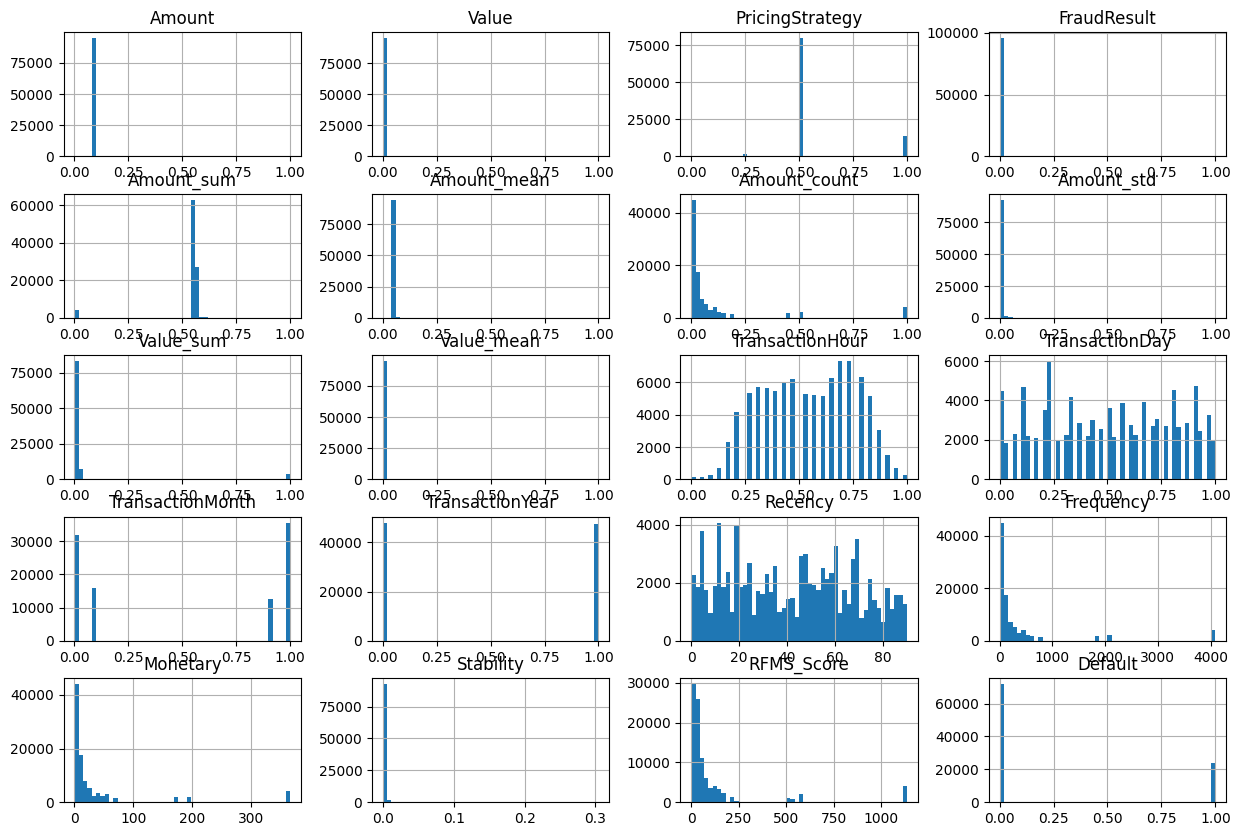

In [20]:
# distribution plots
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize = (15, 10), bins = 50);

In [21]:
# Perform a 70 / 30 split of data
train, test = sc.split_df(df, 'Default', ratio=0.7, seed=999).values()

# Function to compute WOEs
# Drop 'Default', 'Recency', 'Frequency', 'Monetary', and object type columns
var = train.drop(['Default', 'Recency', 'Frequency', 'Monetary'], axis=1)
var = var.select_dtypes(include=['number']).columns # Select only numerical features

y_var = train['Default']

def woe_num(x, y):
    bin_object = Binning(y, n_threshold=50, y_threshold=10, p_threshold=0.35, sign=False)
    global breaks
    breaks = {}
    for i in x:
        bin_object.fit(train[[y, i]])
        breaks[i] = (bin_object.bins[1:-1].tolist())
    return breaks

woe_num(var, 'Default')

{'Amount': [1.0],
 'Value': [0.0012127532819338628,
  0.001258097420667494,
  0.002495749493066699,
  1.0],
 'PricingStrategy': [0.0, 0.25, 0.5, 1.0],
 'FraudResult': [1.0],
 'Amount_sum': [0.5590868103655702,
  0.5591956814300771,
  0.5600683958863238,
  0.5605777110891332,
  0.5627783496408093,
  0.563568973583609,
  0.5670931871751945,
  1.0],
 'Amount_mean': [0.04721991358198111, 1.0],
 'Amount_count': [0.06308068459657701,
  0.06650366748166259,
  0.07090464547677261,
  0.07163814180929094,
  0.07506112469437652,
  1.0],
 'Amount_std': [0.000536875757069204,
  0.0009687747791706623,
  0.0015722172010976896,
  0.0022706030059558846,
  0.003134090762114537,
  0.003870318953890669,
  1.0],
 'Value_sum': [0.0031747965561470717,
  0.004252785630498394,
  0.006160841830715839,
  0.006887839317368598,
  0.010850967993788367,
  0.014394077404231365,
  0.7958126767457945,
  1.0],
 'Value_mean': [0.0001358634922108013,
  0.00014426204444412986,
  0.00295869299209774,
  1.0],
 'TransactionHo

In [22]:
# Check categorical variables names
bins = sc.woebin(train, y = 'Default', x = [
                                            'ProviderId',
                                            'ProductId',
                                            'ProductCategory'], save_breaks_list = 'cat_breaks')

[INFO] creating woe binning ...
[INFO] The breaks_list is saved as cat_breaks_20250128_120758.py


In [23]:
# import dictionary
from cat_breaks_20250128_120758 import breaks_list
breaks_list

{'ProductCategory': ['other%,%ticket%,%transport%,%movies%,%utility_bill%,%data_bundles%,%financial_services',
  'airtime%,%tv'],
 'ProductId': ['ProductId_20%,%ProductId_7%,%ProductId_5%,%ProductId_27%,%ProductId_22%,%ProductId_9%,%ProductId_12%,%ProductId_24%,%ProductId_13%,%ProductId_21%,%ProductId_14%,%ProductId_15',
  'ProductId_4%,%ProductId_16%,%ProductId_11%,%ProductId_1',
  'ProductId_8%,%ProductId_6%,%ProductId_10',
  'ProductId_3%,%ProductId_19%,%ProductId_2'],
 'ProviderId': ['ProviderId_2%,%ProviderId_5%,%ProviderId_3%,%ProviderId_1',
  'ProviderId_6',
  'ProviderId_4']}

In [24]:
# merge
breaks.update(breaks_list)
print(breaks)

{'Amount': [1.0], 'Value': [0.0012127532819338628, 0.001258097420667494, 0.002495749493066699, 1.0], 'PricingStrategy': [0.0, 0.25, 0.5, 1.0], 'FraudResult': [1.0], 'Amount_sum': [0.5590868103655702, 0.5591956814300771, 0.5600683958863238, 0.5605777110891332, 0.5627783496408093, 0.563568973583609, 0.5670931871751945, 1.0], 'Amount_mean': [0.04721991358198111, 1.0], 'Amount_count': [0.06308068459657701, 0.06650366748166259, 0.07090464547677261, 0.07163814180929094, 0.07506112469437652, 1.0], 'Amount_std': [0.000536875757069204, 0.0009687747791706623, 0.0015722172010976896, 0.0022706030059558846, 0.003134090762114537, 0.003870318953890669, 1.0], 'Value_sum': [0.0031747965561470717, 0.004252785630498394, 0.006160841830715839, 0.006887839317368598, 0.010850967993788367, 0.014394077404231365, 0.7958126767457945, 1.0], 'Value_mean': [0.0001358634922108013, 0.00014426204444412986, 0.00295869299209774, 1.0], 'TransactionHour': [0.08695652173913043, 0.13043478260869565, 0.17391304347826086, 0.3

## WOE transformation

In [25]:
# drop TransactionId, AccountId, CustomerId, TransactionStartTime
df = df.drop(['TransactionId', 'AccountId', 'CustomerId', 'TransactionStartTime'], axis=1)

In [26]:
bins_adj = sc.woebin(df, 'Default', breaks_list= breaks, positive = 'bad|0') # change positive to adjust WOE to ln(GOOD / BAD)
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

# Merge by index
train_final = train.merge(train_woe, how = 'left', left_index=True, right_index=True)
test_final = test.merge(test_woe, how = 'left', left_index=True, right_index=True)

[INFO] creating woe binning ...
Binning on 95662 rows and 23 columns in 00:00:17
[INFO] converting into woe values ...
Woe transformating on 66964 rows and 22 columns in 00:00:13
[INFO] converting into woe values ...


{'Amount': <Figure size 640x480 with 2 Axes>,
 'ProviderId': <Figure size 640x480 with 2 Axes>,
 'Value': <Figure size 640x480 with 2 Axes>,
 'FraudResult': <Figure size 640x480 with 2 Axes>,
 'TransactionMonth': <Figure size 640x480 with 2 Axes>,
 'Amount_sum': <Figure size 640x480 with 2 Axes>,
 'ProductCategory': <Figure size 640x480 with 2 Axes>,
 'PricingStrategy': <Figure size 640x480 with 2 Axes>,
 'Stability': <Figure size 640x480 with 2 Axes>,
 'Recency': <Figure size 640x480 with 2 Axes>,
 'RFMS_Score': <Figure size 640x480 with 2 Axes>,
 'TransactionDay': <Figure size 640x480 with 2 Axes>,
 'Frequency': <Figure size 640x480 with 2 Axes>,
 'TransactionYear': <Figure size 640x480 with 2 Axes>,
 'Amount_count': <Figure size 640x480 with 2 Axes>,
 'TransactionHour': <Figure size 640x480 with 2 Axes>,
 'ProductId': <Figure size 640x480 with 2 Axes>,
 'Value_mean': <Figure size 640x480 with 2 Axes>,
 'Amount_std': <Figure size 640x480 with 2 Axes>,
 'Value_sum': <Figure size 640x4

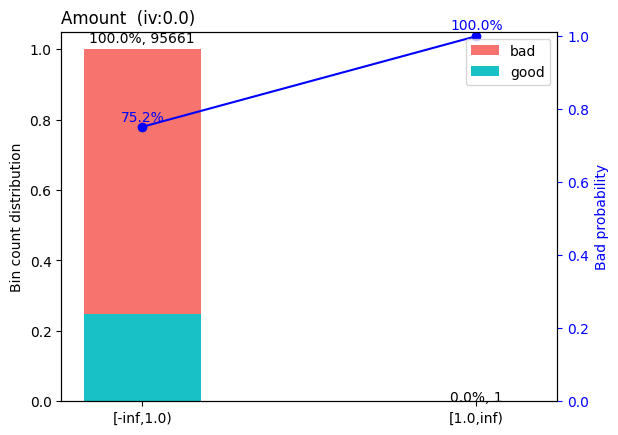

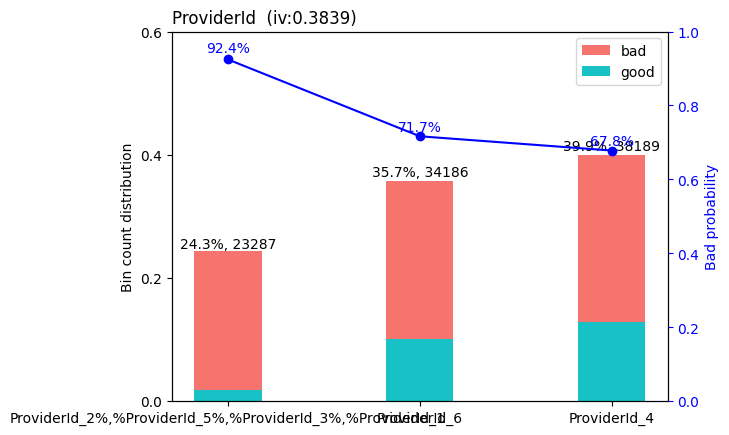

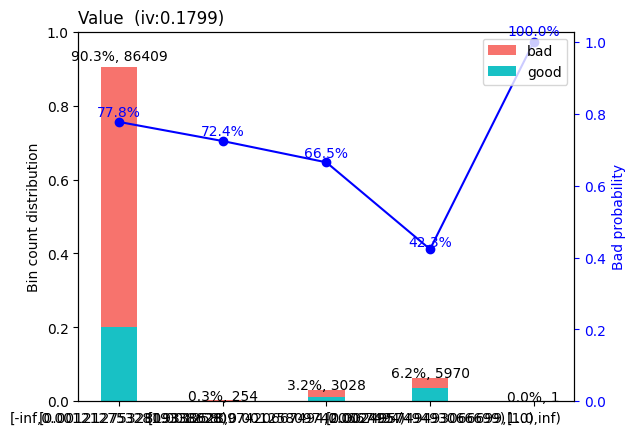

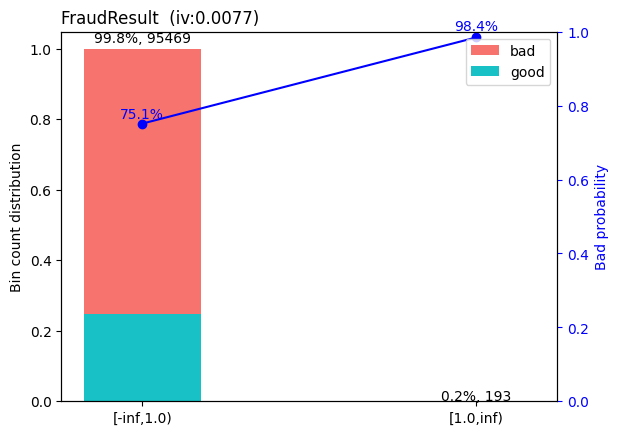

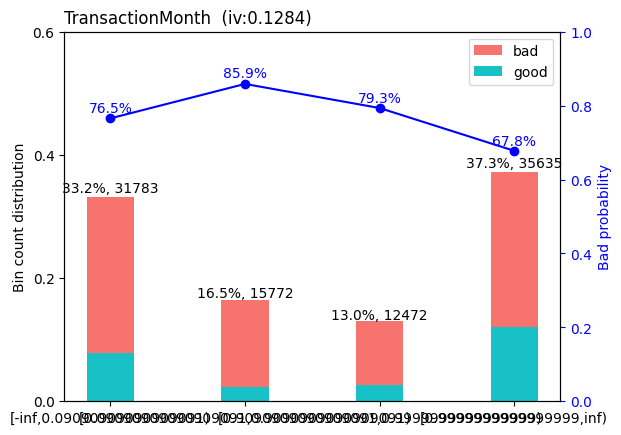

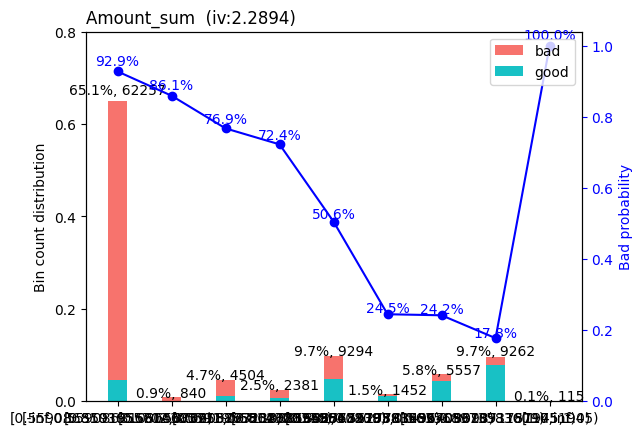

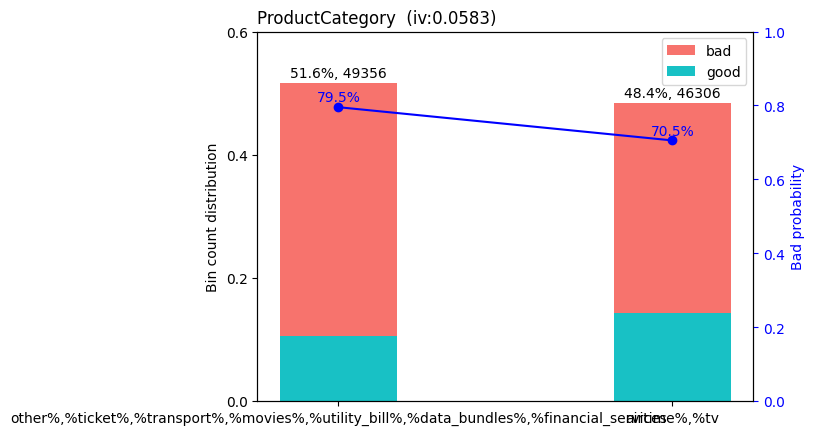

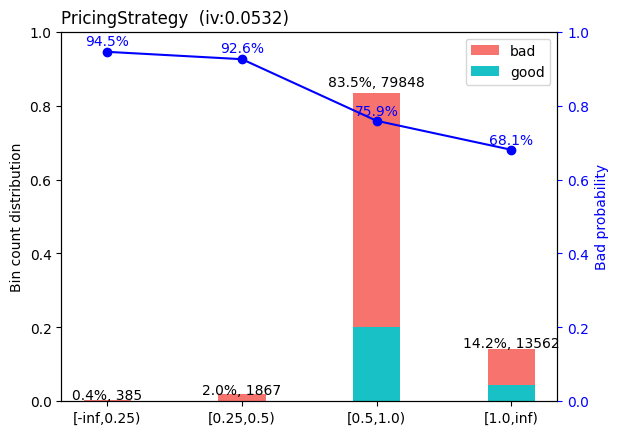

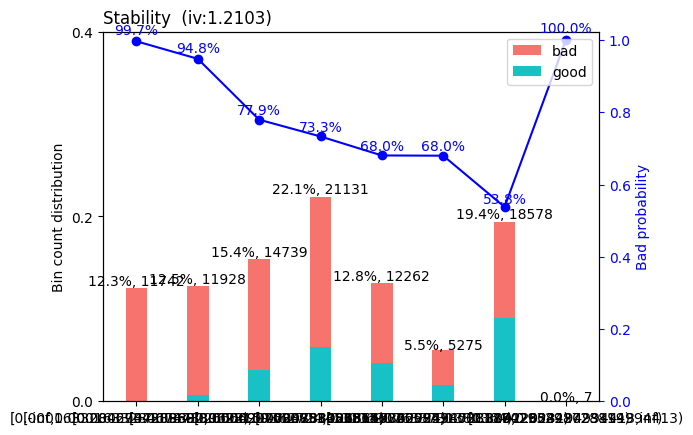

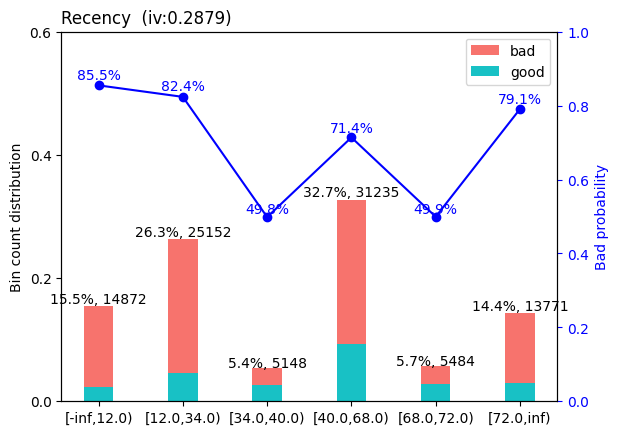

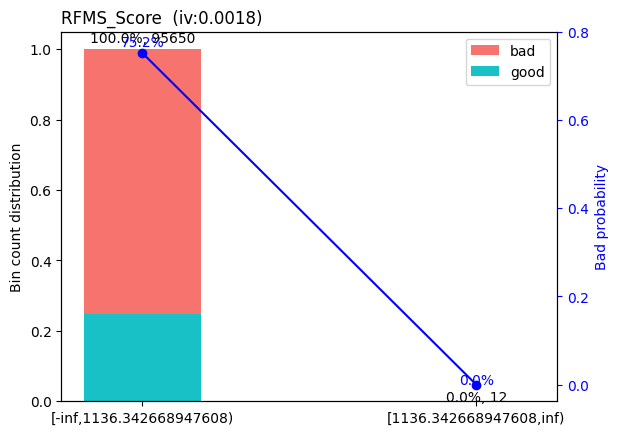

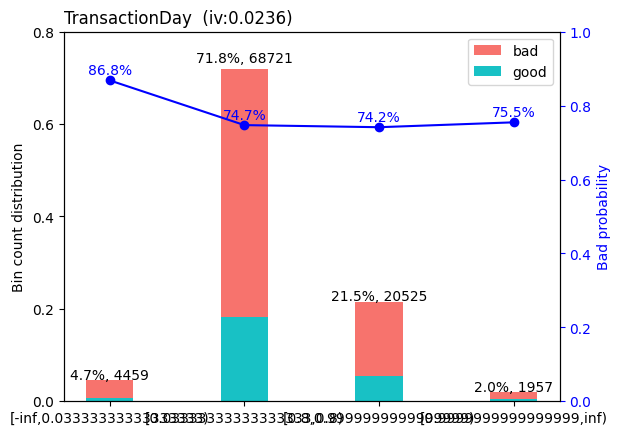

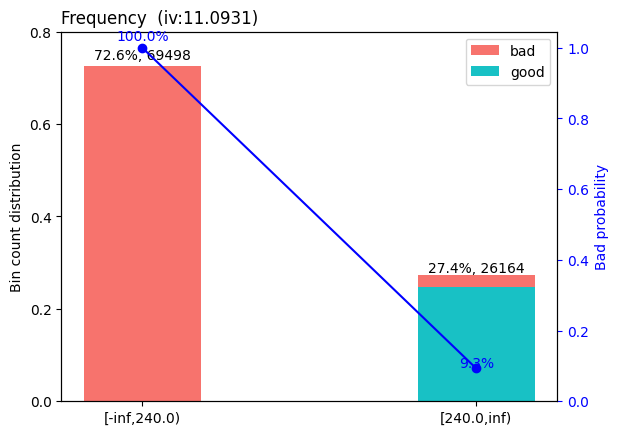

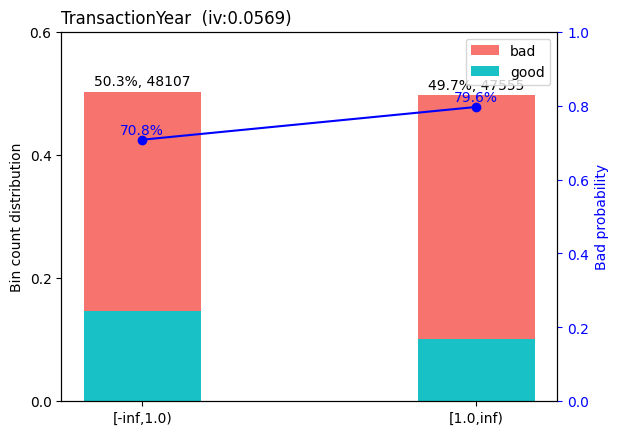

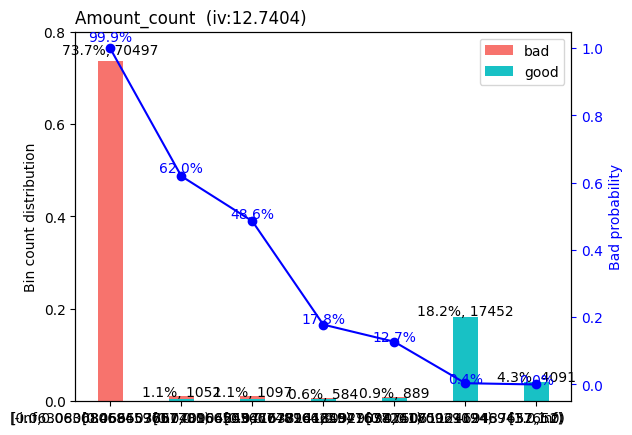

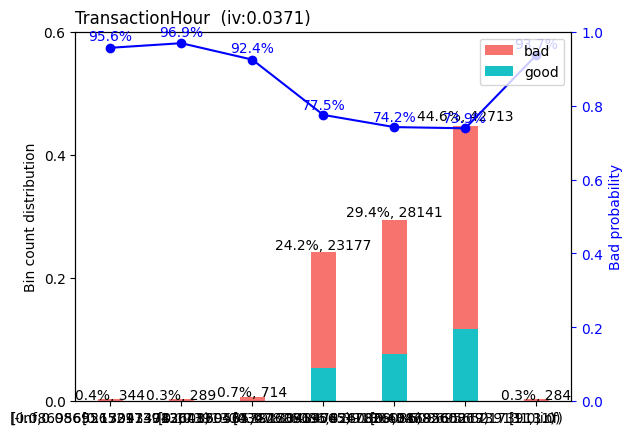

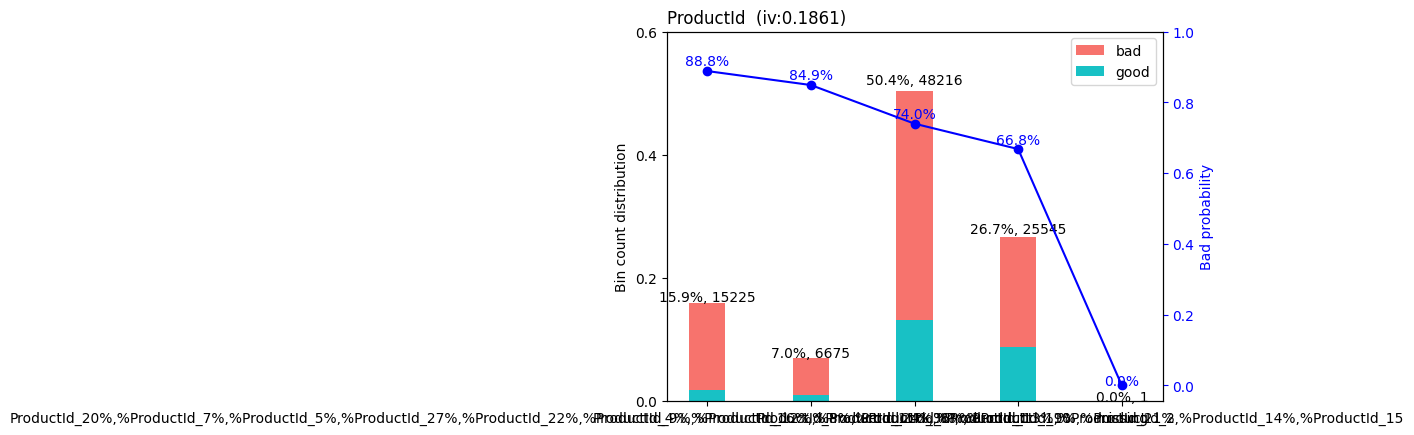

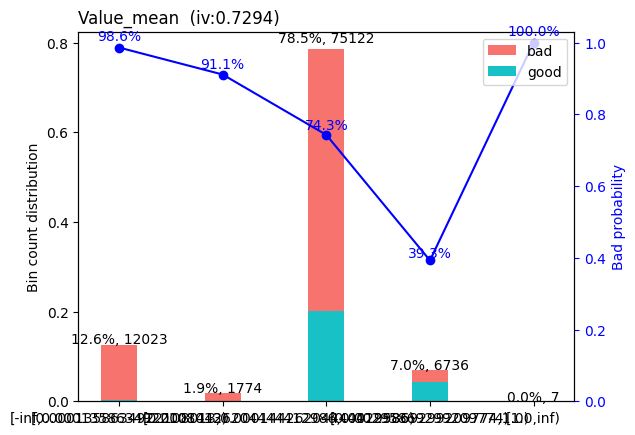

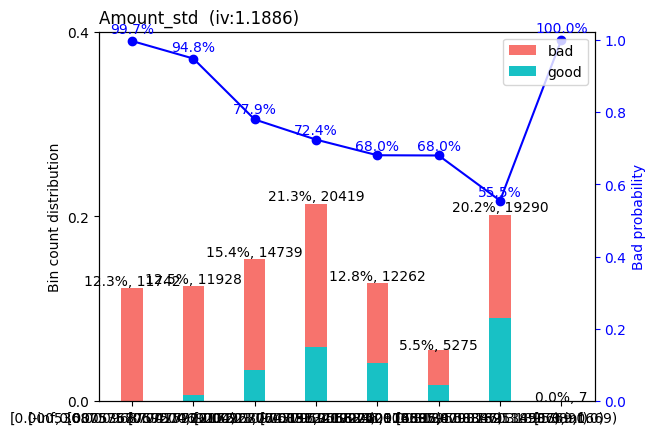

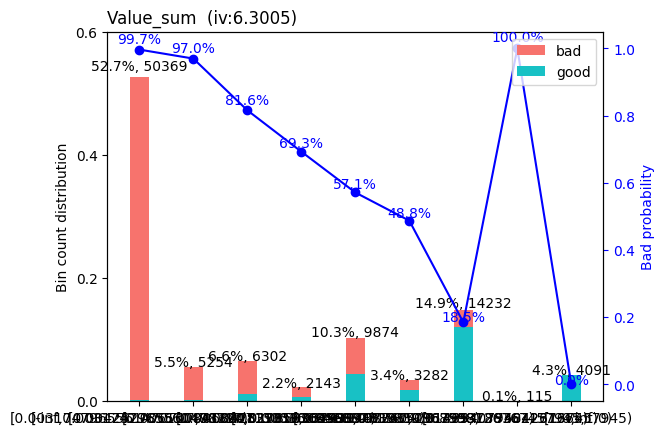

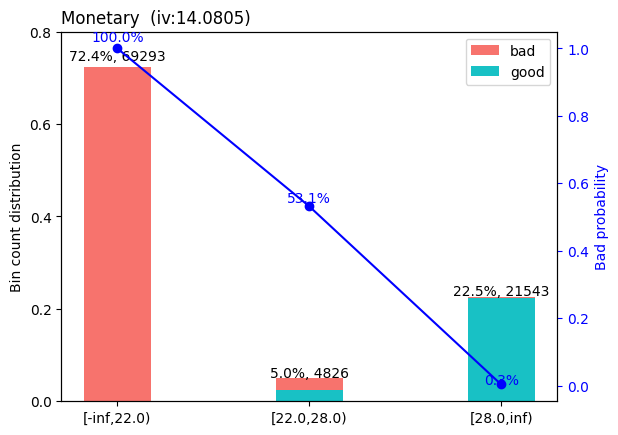

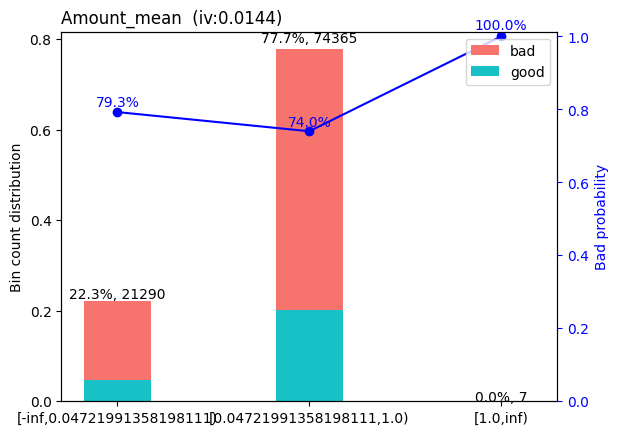

In [27]:
sc.woebin_plot(bins_adj)

##  Apply transformations to df

In [29]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

[INFO] converting into woe values ...
Woe transformating on 66964 rows and 22 columns in 00:00:10
[INFO] converting into woe values ...


##  Merge original variables with WOEs

In [30]:
# Merge by index
train_final = train.merge(train_woe, how = 'left', left_index=True, right_index=True)
test_final = test.merge(test_woe, how = 'left', left_index=True, right_index=True)

In [31]:
df

,ProviderId,ProductId,ProductCategory,Amount,Value,PricingStrategy,FraudResult,Amount_sum,Amount_mean,Amount_count,Amount_std,Value_sum,Value_mean,TransactionHour,TransactionDay,TransactionMonth,TransactionYear,Recency,Frequency,Monetary,Stability,RFMS_Score,Default
0,ProviderId_6,ProductId_10,airtime,0.092004,0.000101,0.5,0.0,0.557522,0.047184,0.028851,0.000919,0.001943,0.000193,0.086957,0.466667,0.909091,0.0,90,119,10.947603,0.000280,54.986971,0
1,ProviderId_4,ProductId_6,financial_services,0.091910,0.000002,0.5,0.0,0.557522,0.047184,0.028851,0.000919,0.001943,0.000193,0.086957,0.466667,0.909091,0.0,90,119,10.947603,0.000280,54.986971,0
2,ProviderId_6,ProductId_1,airtime,0.091958,0.000050,0.5,0.0,0.556944,0.047137,0.000244,0.000000,0.000009,0.000052,0.086957,0.466667,0.909091,0.0,90,2,0.183915,0.000000,23.045979,0
3,ProviderId_1,ProductId_21,utility_bill,0.093750,0.002206,0.5,0.0,0.558153,0.047749,0.009046,0.005187,0.002732,0.000871,0.130435,0.466667,0.909091,0.0,90,38,3.513670,0.001578,32.878812,0
4,ProviderId_4,ProductId_6,financial_services,0.091853,0.000065,0.5,0.0,0.558153,0.047749,0.009046,0.005187,0.002732,0.000871,0.130435,0.466667,0.909091,0.0,90,38,3.513670,0.001578,32.878812,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,ProviderId_4,ProductId_6,financial_services,0.091820,0.000101,0.5,0.0,0.569883,0.047553,0.139853,0.006814,0.024225,0.000510,0.391304,0.400000,0.090909,1.0,0,573,52.889535,0.002073,156.472902,1
95658,ProviderId_6,ProductId_10,airtime,0.092004,0.000101,0.5,0.0,0.557249,0.047233,0.010269,0.000687,0.000601,0.000165,0.391304,0.400000,0.090909,1.0,0,43,3.957583,0.000209,11.739448,0
95659,ProviderId_4,ProductId_6,financial_services,0.091910,0.000002,0.5,0.0,0.557249,0.047233,0.010269,0.000687,0.000601,0.000165,0.391304,0.400000,0.090909,1.0,0,43,3.957583,0.000209,11.739448,0
95660,ProviderId_6,ProductId_19,tv,0.092188,0.000303,0.5,0.0,0.561462,0.047262,0.127873,0.000969,0.009522,0.000216,0.434783,0.400000,0.090909,1.0,0,524,48.240072,0.000295,143.060092,1


In [32]:
train_final.head()

,TransactionId_x,AccountId_x,CustomerId_x,ProviderId,ProductId,ProductCategory,Amount,Value,TransactionStartTime_x,PricingStrategy,FraudResult,Amount_sum,Amount_mean,Amount_count,Amount_std,Value_sum,Value_mean,TransactionHour,TransactionDay,TransactionMonth,TransactionYear,Recency,Frequency,Monetary,Stability,RFMS_Score,Default_x,Default_y,AccountId_y,TransactionStartTime_y,TransactionId_y,CustomerId_y,FraudResult_woe,TransactionMonth_woe,Stability_woe,Recency_woe,Frequency_woe,TransactionHour_woe,ProductId_woe,Value_mean_woe,Amount_std_woe,Amount_mean_woe,Amount_woe,ProviderId_woe,Value_woe,ProductCategory_woe,PricingStrategy_woe,RFMS_Score_woe,TransactionDay_woe,TransactionYear_woe,Amount_count_woe,Value_sum_woe,Monetary_woe,Amount_sum_woe
0,TransactionId_76871,AccountId_3957,CustomerId_4406,ProviderId_6,ProductId_10,airtime,0.092004,0.000101,2018-11-15 02:18:49+00:00,0.5,0.0,0.557522,0.047184,0.028851,0.000919,0.001943,0.000193,0.086957,0.466667,0.909091,0.0,90,119,10.947603,0.000280,54.986971,0,0,AccountId_3957,2018-11-15 02:18:49+00:00,TransactionId_76871,CustomerId_4406,-0.002519,0.237752,1.793743,0.221128,8.094902,2.329424,-0.063891,-0.048131,1.793743,0.232723,0.000024,-0.180581,0.143589,-0.235124,0.038473,0.000493,-0.024355,-0.223833,6.18329,4.603727,8.091947,1.464605
1,TransactionId_73770,AccountId_4841,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,0.091910,0.000002,2018-11-15 02:19:08+00:00,0.5,0.0,0.557522,0.047184,0.028851,0.000919,0.001943,0.000193,0.086957,0.466667,0.909091,0.0,90,119,10.947603,0.000280,54.986971,0,0,AccountId_4841,2018-11-15 02:19:08+00:00,TransactionId_73770,CustomerId_4406,-0.002519,0.237752,1.793743,0.221128,8.094902,2.329424,-0.063891,-0.048131,1.793743,0.232723,0.000024,-0.363442,0.143589,0.249179,0.038473,0.000493,-0.024355,-0.223833,6.18329,4.603727,8.091947,1.464605
3,TransactionId_380,AccountId_648,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,0.093750,0.002206,2018-11-15 03:32:55+00:00,0.5,0.0,0.558153,0.047749,0.009046,0.005187,0.002732,0.000871,0.130435,0.466667,0.909091,0.0,90,38,3.513670,0.001578,32.878812,0,0,AccountId_648,2018-11-15 03:32:55+00:00,TransactionId_380,CustomerId_988,-0.002519,0.237752,-0.956234,0.221128,8.094902,1.395115,0.965758,-0.048131,-0.887408,-0.061792,0.000024,1.395853,-0.421883,0.249179,0.038473,0.000493,-0.024355,-0.223833,6.18329,4.603727,8.091947,1.464605
4,TransactionId_28195,AccountId_4841,CustomerId_988,ProviderId_4,ProductId_6,financial_services,0.091853,0.000065,2018-11-15 03:34:21+00:00,0.5,0.0,0.558153,0.047749,0.009046,0.005187,0.002732,0.000871,0.130435,0.466667,0.909091,0.0,90,38,3.513670,0.001578,32.878812,0,0,AccountId_4841,2018-11-15 03:34:21+00:00,TransactionId_28195,CustomerId_988,-0.002519,0.237752,-0.956234,0.221128,8.094902,1.395115,-0.063891,-0.048131,-0.887408,-0.061792,0.000024,-0.363442,0.143589,0.249179,0.038473,0.000493,-0.024355,-0.223833,6.18329,4.603727,8.091947,1.464605
5,TransactionId_23223,AccountId_1078,CustomerId_1432,ProviderId_6,ProductId_3,airtime,0.092096,0.000202,2018-11-15 03:35:10+00:00,0.5,0.0,0.556949,0.047303,0.000000,0.005449,0.000019,0.000227,0.130435,0.466667,0.909091,0.0,90,1,0.092096,0.000542,37.974688,0,0,AccountId_1078,2018-11-15 03:35:10+00:00,TransactionId_23223,CustomerId_1432,-0.002519,0.237752,-0.097969,0.221128,8.094902,1.395115,-0.409364,-0.048131,-0.887408,-0.061792,0.000024,-0.180581,0.143589,-0.235124,0.038473,0.000493,-0.024355,-0.223833,6.18329,4.603727,8.091947,1.464605


# Merging Datasets with Weight of Evidence (WoE)

In [33]:
train_final = train_final.drop(columns = 'Default_y').rename(columns={'Default_x':'vd'})
test_final = test_final.drop(columns = 'Default_y').rename(columns={'Default_x':'vd'})

In [35]:
# missing check
train_final.stb.missing()

,missing,total,percent
TransactionId_x,0,66964,0.0
AccountId_y,0,66964,0.0
TransactionId_y,0,66964,0.0
CustomerId_y,0,66964,0.0
FraudResult_woe,0,66964,0.0
TransactionMonth_woe,0,66964,0.0
Stability_woe,0,66964,0.0
Recency_woe,0,66964,0.0
Frequency_woe,0,66964,0.0
TransactionHour_woe,0,66964,0.0


In [36]:
# drop categorical variables that were transformed to WOEs
train_final = train_final.drop(['ProviderId', 'ProductId', 'ProductCategory'], axis=1)
test_final = test_final.drop(['ProviderId', 'ProductId', 'ProductCategory'], axis=1)

# Information value (IV)

In [37]:
# Calculate information value (IV) for multiple x variables
sc.iv(train_final, y = 'vd')

,variable,info_value
31,Monetary_woe,13.878016
35,Amount_count_woe,12.586228
44,Amount_count,11.767937
15,Frequency,11.767937
38,Frequency_woe,10.884700
48,Amount_sum,9.291690
46,Value_sum,9.147123
28,Amount_mean,9.095561
23,Value_mean,8.995107
47,Monetary,8.916094


In [38]:
# missing rate, identical value rate.
sc.var_filter(train_final, y = 'vd')

[INFO] filtering variables ...
Variable filtering on 66964 rows and 50 columns in 00:03:02 
9 variables are removed


,CustomerId_y,Value_mean_woe,TransactionMonth,TransactionDay_woe,AccountId_x,AccountId_y,PricingStrategy_woe,Value_woe,TransactionMonth_woe,Stability,Recency,ProductId_woe,Amount_std_woe,Frequency,Amount_sum_woe,TransactionHour,ProductCategory_woe,Stability_woe,Value_mean,Amount_std,Value_sum_woe,CustomerId_x,Amount_mean,Amount,TransactionHour_woe,Monetary_woe,Value,TransactionYear_woe,Amount_count_woe,PricingStrategy,Frequency_woe,RFMS_Score,TransactionDay,TransactionYear,Recency_woe,Amount_count,ProviderId_woe,Value_sum,Monetary,Amount_sum,vd
0,CustomerId_4406,-0.048131,0.909091,-0.024355,AccountId_3957,AccountId_3957,0.038473,0.143589,0.237752,0.000280,90,-0.063891,1.793743,119,1.464605,0.086957,-0.235124,1.793743,0.000193,0.000919,4.603727,CustomerId_4406,0.047184,0.092004,2.329424,8.091947,0.000101,-0.223833,6.183290,0.5,8.094902,54.986971,0.466667,0.0,0.221128,0.028851,-0.180581,0.001943,10.947603,0.557522,0
1,CustomerId_4406,-0.048131,0.909091,-0.024355,AccountId_4841,AccountId_4841,0.038473,0.143589,0.237752,0.000280,90,-0.063891,1.793743,119,1.464605,0.086957,0.249179,1.793743,0.000193,0.000919,4.603727,CustomerId_4406,0.047184,0.091910,2.329424,8.091947,0.000002,-0.223833,6.183290,0.5,8.094902,54.986971,0.466667,0.0,0.221128,0.028851,-0.363442,0.001943,10.947603,0.557522,0
3,CustomerId_988,-0.048131,0.909091,-0.024355,AccountId_648,AccountId_648,0.038473,-0.421883,0.237752,0.001578,90,0.965758,-0.887408,38,1.464605,0.130435,0.249179,-0.956234,0.000871,0.005187,4.603727,CustomerId_988,0.047749,0.093750,1.395115,8.091947,0.002206,-0.223833,6.183290,0.5,8.094902,32.878812,0.466667,0.0,0.221128,0.009046,1.395853,0.002732,3.513670,0.558153,0
4,CustomerId_988,-0.048131,0.909091,-0.024355,AccountId_4841,AccountId_4841,0.038473,0.143589,0.237752,0.001578,90,-0.063891,-0.887408,38,1.464605,0.130435,0.249179,-0.956234,0.000871,0.005187,4.603727,CustomerId_988,0.047749,0.091853,1.395115,8.091947,0.000065,-0.223833,6.183290,0.5,8.094902,32.878812,0.466667,0.0,0.221128,0.009046,-0.363442,0.002732,3.513670,0.558153,0
5,CustomerId_1432,-0.048131,0.909091,-0.024355,AccountId_1078,AccountId_1078,0.038473,0.143589,0.237752,0.000542,90,-0.409364,-0.887408,1,1.464605,0.130435,-0.235124,-0.097969,0.000227,0.005449,4.603727,CustomerId_1432,0.047303,0.092096,1.395115,8.091947,0.000202,-0.223833,6.183290,0.5,8.094902,37.974688,0.466667,0.0,0.221128,0.000000,-0.180581,0.000019,0.092096,0.556949,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95654,CustomerId_960,-0.048131,0.090909,-0.024355,AccountId_620,AccountId_620,0.038473,0.143589,0.695654,0.000589,0,0.617370,-0.145025,44,1.464605,0.391304,-0.235124,-0.097969,0.000352,0.001938,4.603727,CustomerId_960,0.047386,0.092004,-0.052609,8.091947,0.000101,0.255570,6.183290,0.5,8.094902,12.013952,0.400000,1.0,0.664298,0.010513,-0.180581,0.001292,4.055220,0.557580,0
95656,CustomerId_3078,-0.048131,0.090909,-0.024355,AccountId_2659,AccountId_2659,0.038473,-1.417413,0.695654,0.002073,0,-0.063891,-0.887408,573,-2.639267,0.391304,-0.235124,-0.956234,0.000510,0.006814,-2.590910,CustomerId_3078,0.047553,0.096507,-0.052609,-6.893224,0.005061,0.255570,-6.681919,0.5,-3.388974,156.472902,0.400000,1.0,0.664298,0.139853,-0.180581,0.024225,52.889535,0.569883,1
95658,CustomerId_3874,-0.048131,0.090909,-0.024355,AccountId_3439,AccountId_3439,0.038473,0.143589,0.695654,0.000209,0,-0.063891,1.793743,43,1.464605,0.391304,-0.235124,1.793743,0.000165,0.000687,4.603727,CustomerId_3874,0.047233,0.092004,-0.052609,8.091947,0.000101,0.255570,6.183290,0.5,8.094902,11.739448,0.400000,1.0,0.664298,0.010269,-0.180581,0.000601,3.957583,0.557249,0
95659,CustomerId_3874,-0.048131,0.090909,-0.024355,AccountId_4841,AccountId_4841,0.038473,0.143589,0.695654,0.000209,0,-0.063891,1.793743,43,1.464605,0.391304,0.249179,1.793743,0.000165,0.000687,4.603727,CustomerId_3874,0.047233,0.091910,-0.052609,8.091947,0.000002

# MODEL

## Logistic Regression

In [39]:
# Data split
y_train = train_final.loc[:,'vd']
X_train = train_final.loc[:,train_final.columns != 'vd']
y_test = test_final.loc[:,'vd']
X_test = test_final.loc[:,train_final.columns != 'vd']

# Select only numerical features for Logistic Regression
X_train_numerical = X_train.select_dtypes(include=np.number)
X_test_numerical = X_test.select_dtypes(include=np.number)

In [40]:
from sklearn.linear_model import LogisticRegression

# Specify the solver as 'liblinear' to use L1 penalty
lr = LogisticRegression(penalty='l1', C=0.9, solver='liblinear')

# Fit the model using only numerical features
lr.fit(X_train_numerical, y_train)

# Print the coefficients
print(lr.coef_)

[[  0.           0.          -0.20594663   0.         -18.97822553
    0.           0.           0.           0.           0.
   -0.18028004  -1.0775398  -15.73778161 -15.05449848   0.33869157
    0.02815774   0.27917644   0.           0.10764083   0.
    0.           2.63119998   0.10439067  -0.40179506   0.
    0.05806602  -0.77905438   0.           0.           0.
    0.04115923   0.           0.           0.           0.
    0.38489065   0.          -1.79303087  -0.24608406   0.10454351
   -2.1235796 ]]


In [41]:
# check for missin values in X_test_numerical
X_test_numerical.isna().sum()

,0
Amount,0
Value,0
PricingStrategy,0
FraudResult,0
Amount_sum,0
Amount_mean,0
Amount_count,0
Amount_std,0
Value_sum,0
Value_mean,0


In [42]:
# impute missing value with mean
X_test_numerical = X_test_numerical.fillna(X_test_numerical.mean())

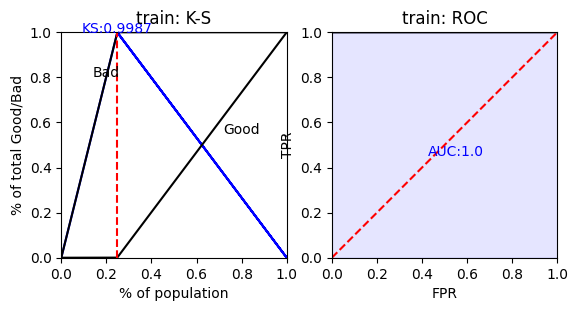

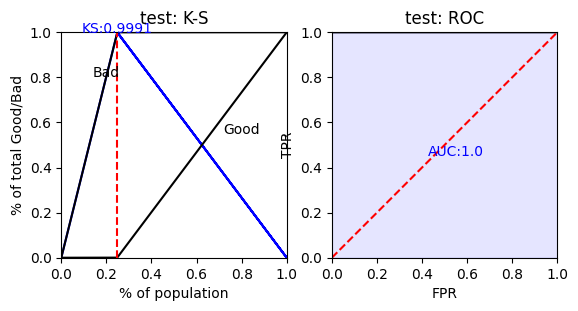

In [43]:
# Predicted probability for training data
train_pred = lr.predict_proba(X_train_numerical)[:, 1]

# Predicted probability for testing data
test_pred = lr.predict_proba(X_test_numerical)[:, 1]

# Performance evaluation on training data
train_perf = sc.perf_eva(y_train, train_pred, title="train")

# Performance evaluation on testing data
test_perf = sc.perf_eva(y_test, test_pred, title="test")

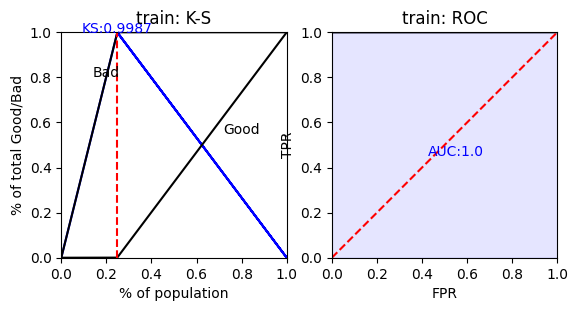

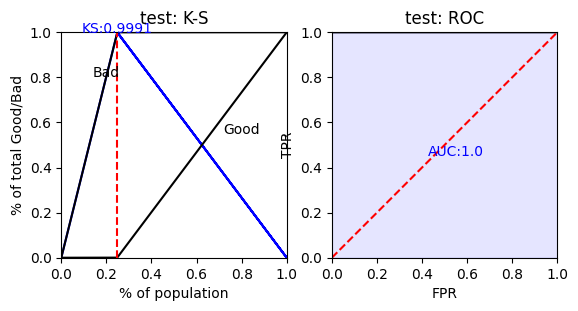

In [44]:
# Predicted Probabilities
train_pred = lr.predict_proba(X_train_numerical)[:,1]
test_pred = lr.predict_proba(X_test_numerical)[:,1]

# Performance Evaluation for K-S and ROC
train_perf = sc.perf_eva(y_train, train_pred, title="train")
test_perf = sc.perf_eva(y_test, test_pred, title="test")

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, roc_curve

#predictions = lr.predict(X_test)
predictions = lr.predict(X_test_numerical)
print('Accuracy')
print(accuracy_score(y_test, predictions))
print('AUC Score')
print(roc_auc_score(y_test, predictions))

Accuracy
0.9993030873231584
AUC Score
0.9991133190361906


In [46]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21575
           1       1.00      1.00      1.00      7123

    accuracy                           1.00     28698
   macro avg       1.00      1.00      1.00     28698
weighted avg       1.00      1.00      1.00     28698



Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

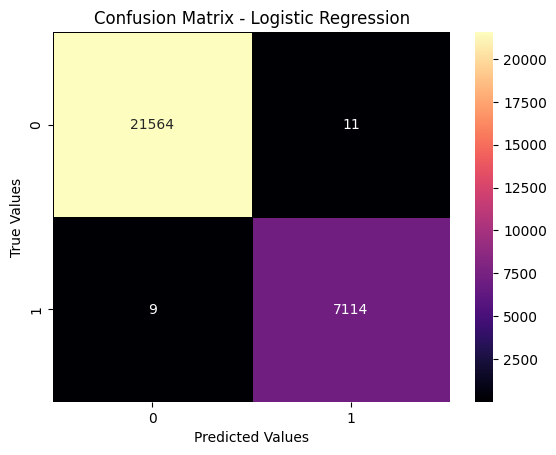

In [47]:
conf_log2 = confusion_matrix(y_test,predictions)
sns.heatmap(data=conf_log2, annot=True, linewidth=0.7, linecolor='k', fmt='.0f', cmap='magma')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix - Logistic Regression')

## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
# Fit the model using only numerical features
rf.fit(X_train_numerical, y_train)

RandomForestClassifier(random_state=42)

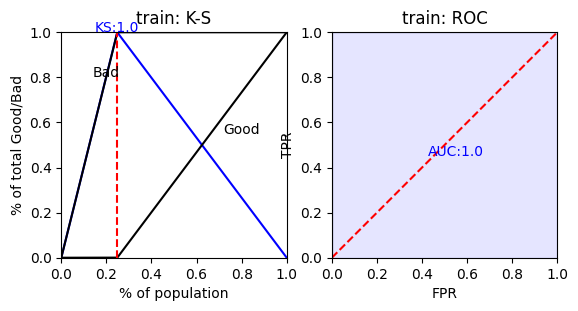

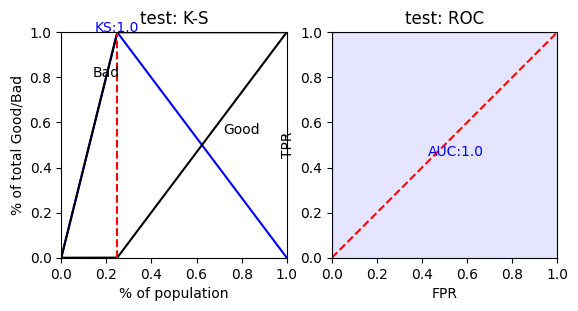

In [49]:
# Predicted probability for training data
train_pred = rf.predict_proba(X_train_numerical)[:, 1]

# Predicted probability for testing data
test_pred = rf.predict_proba(X_test_numerical)[:, 1]

# Performance evaluation on training data
train_perf = sc.perf_eva(y_train, train_pred, title="train")

# Performance evaluation on testing data
test_perf = sc.perf_eva(y_test, test_pred, title="test")

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluate the model
y_pred = rf.predict(X_test_numerical)
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred)}")

Random Forest Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0


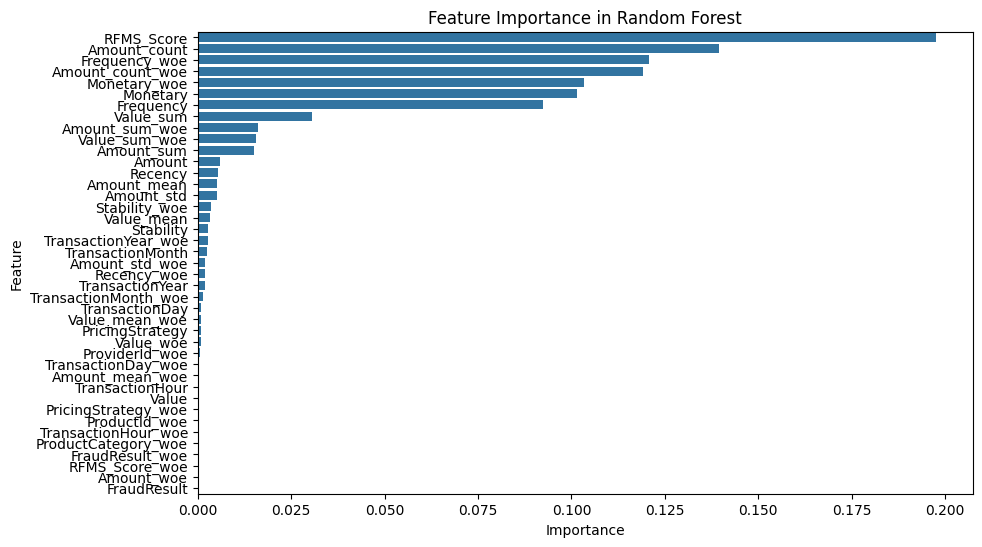

In [51]:
# visualize feature importances for better understanding
importances = rf.feature_importances_
feature_names = X_train_numerical.columns  # Assuming X_train_numerical has column names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()